# Introduction

This is a demo for an application applying AI for fashion to extract principal color from a clothing of an image. Then predict the trending of this color using the past record from Amazon dataset. There are three modules in this demo:

1/ The clothes segmentation module

2/ The color extraction module

3/ The trend forecasting module

In [26]:
# Import modules
import maskrcnn_modanet.processimages as processimages
from maskrcnn_modanet.processimages import loadModel, main

import pandas as pd
import numpy as np
import skimage.io as io
import json
import cv2

import matplotlib.pyplot as plt
from pycocotools.coco import COCO

import keras
import os
from keras_retinanet.utils.transform import random_transform_generator
import keras.preprocessing.image
import tensorflow as tf

import keras_retinanet.losses
from keras_retinanet.callbacks import RedirectModel
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

from keras_maskrcnn import losses, models

## 0. Data Analysis

In [2]:
ann_train_path = '/home/vankhoa/datasets/modanet/datasets/coco/annotations/instances_train.json'
ann_val_path = '/home/vankhoa/datasets/modanet/datasets/coco/annotations/instances_train.json'
ann_test_path = '/home/vankhoa/datasets/modanet/datasets/coco/annotations/instances_train.json'
path = '/home/vankhoa/datasets/modanet'
coco_path = '/home/vankhoa/datasets/modanet/datasets/coco/'
snapshot_path = '/home/vankhoa/dataset/modanet/results/snapshots/'

In [10]:
# open one annotation coco
with open(ann_train_path, 'r') as f:
    data = json.load(f)
print(data.keys())
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])
print(len(data['images']), len(data['annotations']), len(data['categories']))

# open one annotation coco
with open(ann_val_path, 'r') as f:
    data = json.load(f)
print(data.keys())
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])
print(len(data['images']), len(data['annotations']), len(data['categories']))

# open one annotation coco
with open(ann_test_path, 'r') as f:
    data = json.load(f)
print(data.keys())
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])
print(len(data['images']), len(data['annotations']), len(data['categories']))

dict_keys(['year', 'categories', 'annotations', 'licenses', 'type', 'info', 'images'])
{'file_name': '0736791.jpg', 'width': 400, 'id': 736791, 'license': 3, 'height': 600}
{'segmentation': [[161, 248, 170, 248, 173, 249, 189, 251, 199, 252, 199, 250, 212, 250, 212, 252, 224, 253, 239, 251, 248, 250, 257, 247, 257, 253, 249, 255, 248, 260, 248, 265, 228, 264, 215, 264, 200, 264, 196, 261, 189, 260, 182, 259, 171, 259, 164, 255, 160, 254, 161, 254]], 'area': 1746, 'iscrowd': 0, 'image_id': 736791, 'bbox': [160, 247, 97, 18], 'category_id': 2, 'id': 0}
{'supercategory': 'fashion', 'id': 1, 'name': 'bag'}
41877 219777 13
dict_keys(['year', 'categories', 'annotations', 'licenses', 'type', 'info', 'images'])
{'file_name': '0736791.jpg', 'width': 400, 'id': 736791, 'license': 3, 'height': 600}
{'segmentation': [[161, 248, 170, 248, 173, 249, 189, 251, 199, 252, 199, 250, 212, 250, 212, 252, 224, 253, 239, 251, 248, 250, 257, 247, 257, 253, 249, 255, 248, 260, 248, 265, 228, 264, 215, 264, 20

In [11]:
# count number of images, plot one images

# Initialize the COCO api for instance annotations
coco=COCO(ann_train_path)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

print('The class name is', getClassName(7, cats))

loading annotations into memory...
Done (t=1.22s)
creating index...
index created!
[{'supercategory': 'fashion', 'id': 1, 'name': 'bag'}, {'supercategory': 'fashion', 'id': 2, 'name': 'belt'}, {'supercategory': 'fashion', 'id': 3, 'name': 'boots'}, {'supercategory': 'fashion', 'id': 4, 'name': 'footwear'}, {'supercategory': 'fashion', 'id': 5, 'name': 'outer'}, {'supercategory': 'fashion', 'id': 6, 'name': 'dress'}, {'supercategory': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'supercategory': 'fashion', 'id': 8, 'name': 'pants'}, {'supercategory': 'fashion', 'id': 9, 'name': 'top'}, {'supercategory': 'fashion', 'id': 10, 'name': 'shorts'}, {'supercategory': 'fashion', 'id': 11, 'name': 'skirt'}, {'supercategory': 'fashion', 'id': 12, 'name': 'headwear'}, {'supercategory': 'fashion', 'id': 13, 'name': 'scarf/tie'}]
The class name is sunglasses


[6]
Number of images containing all the  classes: 41877
0374380.jpg


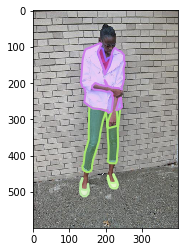

In [19]:
# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms='dress') 
print(catIds)

# Get all images containing the above Category IDs
imgIds = coco.getImgIds()
print("Number of images containing all the  classes:", len(imgIds))

idx = np.random.randint(0,len(imgIds))


# load and display a random image
img = coco.loadImgs(imgIds[idx])[0]
print(img['file_name'])
I = io.imread('{}/images/{}'.format(coco_path,img['file_name']))/255.0

plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

## 1. Dataloader

In [7]:
transform_generator = random_transform_generator(flip_x_chance=0.5)

# import here to prevent unnecessary dependency on cocoapi
from maskrcnn_modanet.train.coco import CocoGenerator

train_generator = CocoGenerator(
    coco_path,
    'train',
    transform_generator=transform_generator,
    batch_size=4,
    config=None,
    image_min_side=800,
    image_max_side=1333
)

validation_generator = CocoGenerator(
    coco_path,
    'val',
    batch_size=1,
    config=None,
    image_min_side=800,
    image_max_side=1333
)

loading annotations into memory...
Done (t=1.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


## 2. Training

In [8]:
# Model
    
backbone = models.backbone('resnet50')

model  = backbone.maskrcnn(
            num_classes=train_generator.num_classes(),
            nms=True,
            class_specific_filter=True,
            modifier=None,
            anchor_params=None
        )


# compile model
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal(),
        'masks'         : losses.mask(),
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "retinanet-mask"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        image[0][0]                      
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
_____________

In [9]:
callbacks = []

# save the prediction model
# ensure directory created first; otherwise h5py will error after epoch.
os.makedirs(snapshot_path, exist_ok=True)
checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(
        snapshot_path,
        '{backbone}_{dataset_type}_{{epoch:02d}}.h5'.format(backbone='resnet50', dataset_type='coco')
    ),
    verbose=1
)
checkpoint = RedirectModel(checkpoint, model)
callbacks.append(checkpoint)

tensorboard_callback = None


from keras_maskrcnn.callbacks.coco import CocoEval

# use prediction model for evaluation
evaluation = CocoEval(validation_generator)
evaluation = RedirectModel(evaluation, model)
callbacks.append(evaluation)

In [10]:
model.fit_generator(
        generator=train_generator,
        steps_per_epoch=100,
        epochs=3,
        verbose=1,
        callbacks=callbacks,
        workers=8,
        use_multiprocessing=True,
        max_queue_size=10
    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
  9/100 [=>............................] - ETA: 43:40 - loss: 70939.0009 - regression_loss: 166.1348 - classification_loss: 70772.8668 - masks_loss: 0.0000e+00

Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


## 3. Inference

The clothes segmentation module based on the mask-rcnn model used for instance segmentation. The model is trained on Modanet dataset https://github.com/eBay/modanet, a street fashion images dataset consisting of annotations related to RGB images. ModaNet provides multiple polygon annotations for each image. This dataset is described in a technical paper with the title ModaNet: A Large-Scale Street Fashion Dataset with Polygon Annotations. Each polygon is associated with a label from 13 meta fashion categories. The annotations are based on images in the PaperDoll image set.

In [6]:
# Load segmentation model
labels_to_names = {0: 'bag', 1: 'belt', 2: 'boots', 3: 'footwear', 4: 'outer', 5: 'dress', 6: 'sunglasses', 7: 'pants', 8: 'top', 9: 'shorts', 10: 'skirt', 11: 'headwear', 12: 'scarf/tie'}

model_path = path + '/results/resnet50_modanet.h5'
model = models.load_model(model_path, backbone_name='resnet50')

In [34]:
def predict(img_path):
    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    outputs = model.predict_on_batch(np.expand_dims(image, axis=0))

    boxes  = outputs[-4][0]
    scores = outputs[-3][0]
    labels = outputs[-2][0]
    masks  = outputs[-1][0]

    # correct for image scale
    boxes /= scale

    for box, score, label, mask in zip(boxes, scores, labels, masks):
        if score < 0.5:
            break
        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        mask = mask[:, :, label]
        draw_mask(draw, b, mask, color=label_color(label))

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
    return draw

In [39]:
idx = np.random.randint(0,len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[idx])[0]
print(img['file_name'])
I = io.imread('{}/images/{}'.format(coco_path,img['file_name']))/255.0

0175566.jpg


In [40]:
draw = predict(coco_path + '/images/' + img['file_name'])

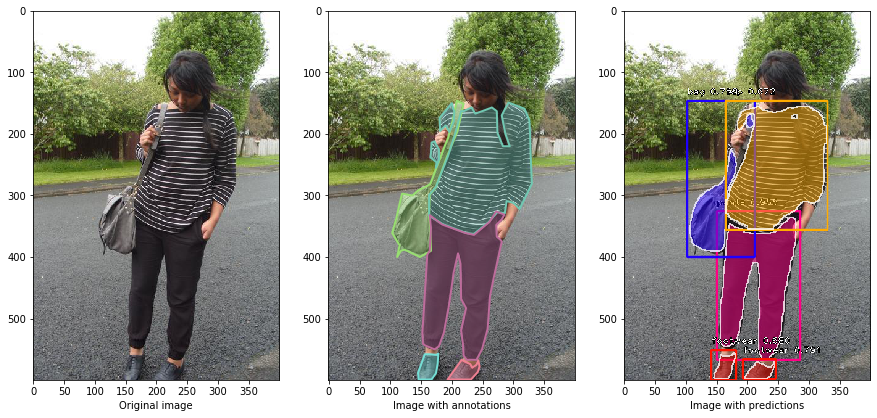

In [43]:
f = plt.figure(figsize=(15, 15))
ax = f.add_subplot(1,3, 1)
plt.imshow(I)
ax.set_xlabel('Original image')

ax = f.add_subplot(1,3,2)
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
ax.set_xlabel('Image with annotations')

ax = f.add_subplot(1,3,3)
plt.imshow(draw)
ax.set_xlabel('Image with predictions')

plt.show()